In [ ]:
# preprocessing functional near-infrared spectroscopy(fNIRS) data

In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress

import mne


fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
fnirs_cw_amplitude_dir = op.join(fnirs_data_folder, 'Participant-1')
raw_intensity = mne.io.read_raw_nirx(fnirs_cw_amplitude_dir, verbose=True)
raw_intensity.load_data()

Using default location ~/mne_data for fnirs_motor...


100%|█████████████████████████████████████| 17.9M/17.9M [00:00<00:00, 17.3GB/s]
Untarring contents of '/Users/DanDan/mne_data/MNE-fNIRS-motor-data.tgz' to '/Users/DanDan/mne_data'


Loading /Users/DanDan/mne_data/MNE-fNIRS-motor-data/Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


<RawNIRX | Participant-1, 56 x 23239 (2974.5 s), ~10.0 MB, data loaded>

In [2]:
raw_intensity.annotations.set_durations(5)
raw_intensity.annotations.rename({'1.0': 'Control',
                                  '2.0': 'Tapping/Left',
                                  '3.0': 'Tapping/Right'})
unwanted = np.nonzero(raw_intensity.annotations.description == '15.0')
raw_intensity.annotations.delete(unwanted)

In [3]:
subjects_dir = op.join(mne.datasets.sample.data_path(), 'subjects')

brain = mne.viz.Brain(
    'fsaverage', subjects_dir=subjects_dir, background='w', cortex='0.5')
brain.add_sensors(
    raw_intensity.info, trans='fsaverage',
    fnirs=['channels', 'pairs', 'sources', 'detectors'])
brain.show_view(azimuth=20, elevation=60, distance=400)

Using notebook 3d backend.



Channel types::	fnirs_cw_amplitude: 56


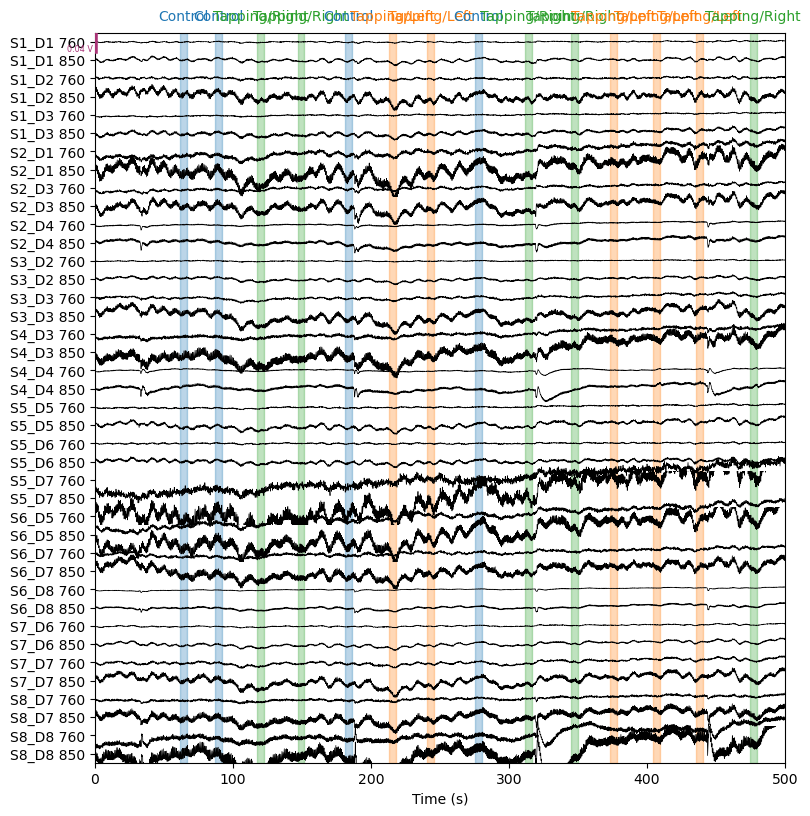

In [7]:
picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True)
dists = mne.preprocessing.nirs.source_detector_distances(
    raw_intensity.info, picks=picks)
raw_intensity.pick(picks[dists > 0.01])
raw_intensity.plot(n_channels=len(raw_intensity.ch_names),
                   duration=500, show_scrollbars=False);

convert raw intensity --> optical density

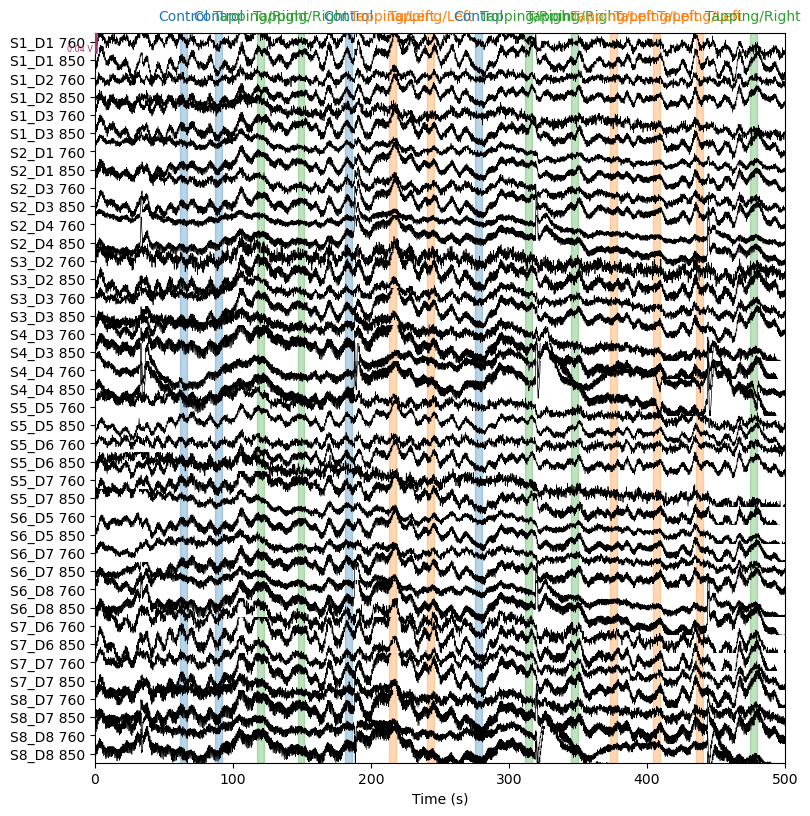

In [10]:
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_od.plot(n_channels=len(raw_od.ch_names),
            duration=500, show_scrollbars=False);

In [20]:
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
fig, ax = plt.subplots()
ax.hist(sci)
ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])

[Text(0.5, 0, 'Scalp Coupling Index'), Text(0, 0.5, 'Count'), (0.0, 1.0)]

In [16]:
raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))

converting optical density --> haemoglobin

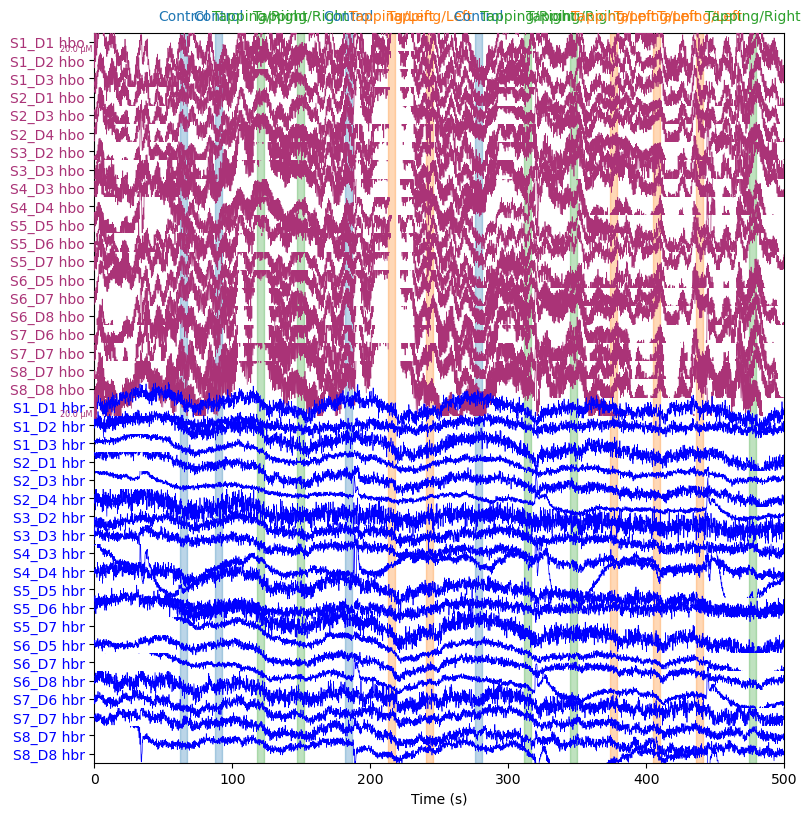

In [22]:
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)
raw_haemo.plot(n_channels=len(raw_haemo.ch_names),
               duration=500, show_scrollbars=False);

In [23]:
fig = raw_haemo.plot_psd(average=True)
fig.suptitle('Before filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)
raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
                             l_trans_bandwidth=0.02)
fig = raw_haemo.plot_psd(average=True)
fig.suptitle('After filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 32.768 (s)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 sec)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 32.768 (s)


/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished
/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


In [24]:
# signal has been converted to relative haemoglobin concentration
# unwanted heart rate compontent has been removed

Used Annotations descriptions: ['Control', 'Tapping/Left', 'Tapping/Right']


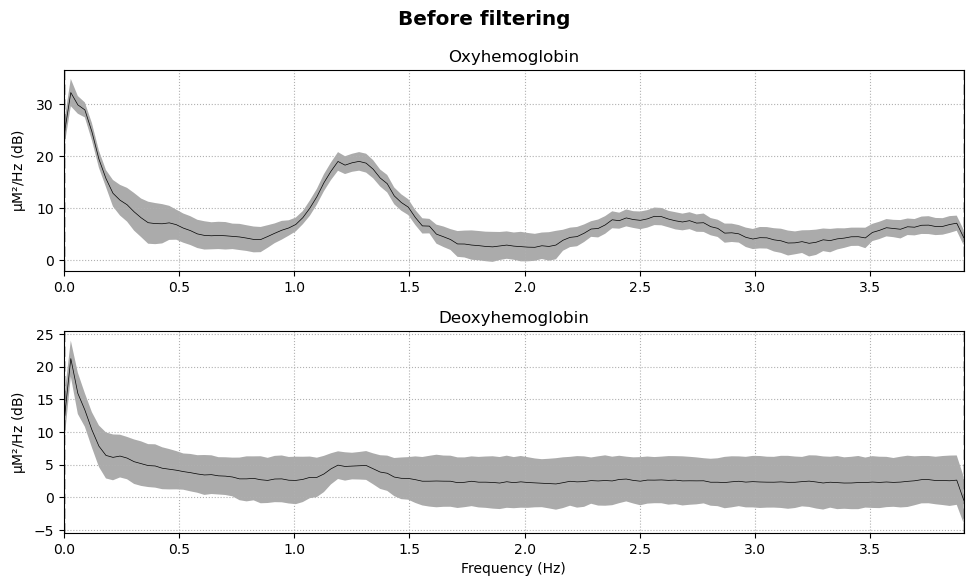

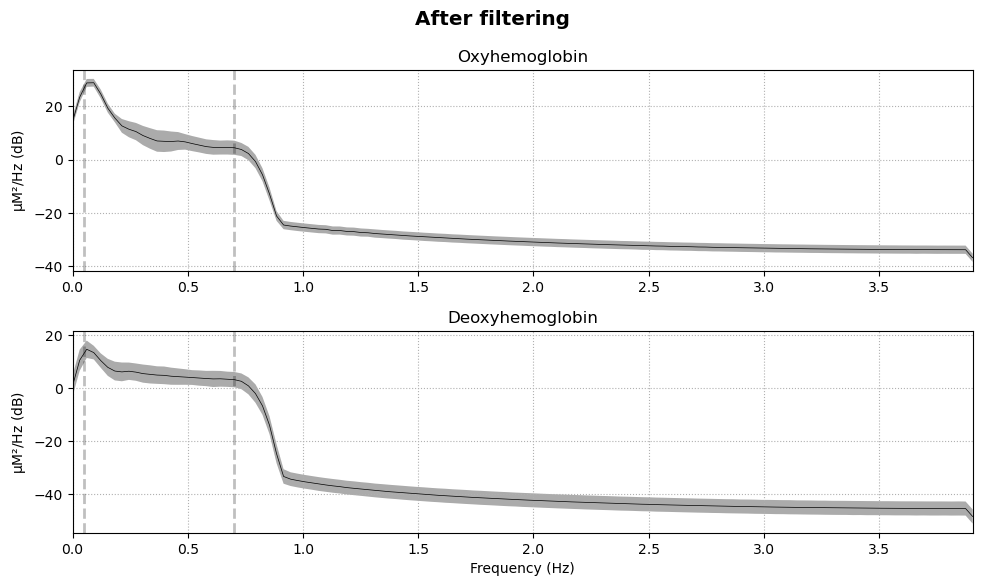

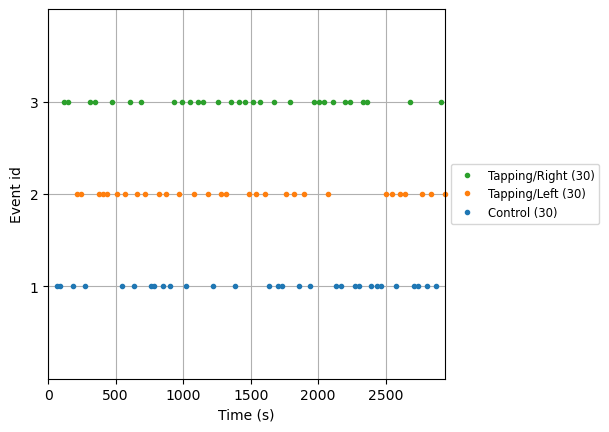

In [25]:
events, event_dict = mne.events_from_annotations(raw_haemo)
fig = mne.viz.plot_events(events, event_id=event_dict,
                          sfreq=raw_haemo.info['sfreq'])
fig.subplots_adjust(right=0.7)  # make room for the legend

Not setting metadata
90 matching events found
Setting baseline interval to [-4.992, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 157 original time points ...
    Rejecting  epoch based on HBO : ['S4_D4 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo', 'S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo', 'S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S1_D1 hbo', 'S3_D3 hbo', 'S4_D4 hbo', 'S7_D6 hbo', 'S7_D7 hbo', 'S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo', 'S6_D8 hbo', 'S8_D8 hbo']
6 bad epochs dropped


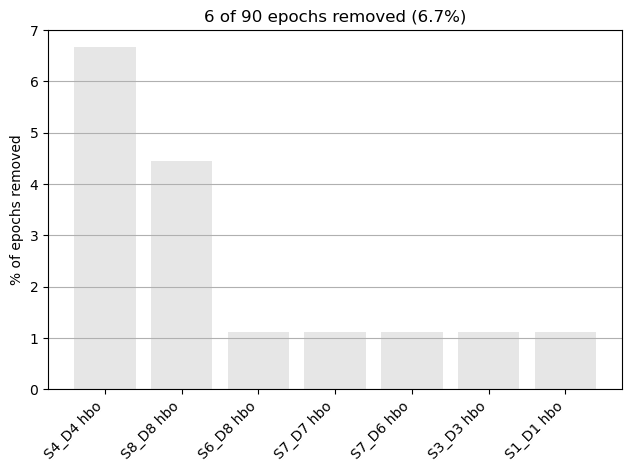

In [27]:
reject_criteria = dict(hbo=80e-6)
tmin, tmax = -5, 15

epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                    tmin=tmin, tmax=tmax,
                    reject=reject_criteria, reject_by_annotation=True,
                    proj=True, baseline=(None, 0), preload=True,
                    detrend=None, verbose=True)
epochs.plot_drop_log();

Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


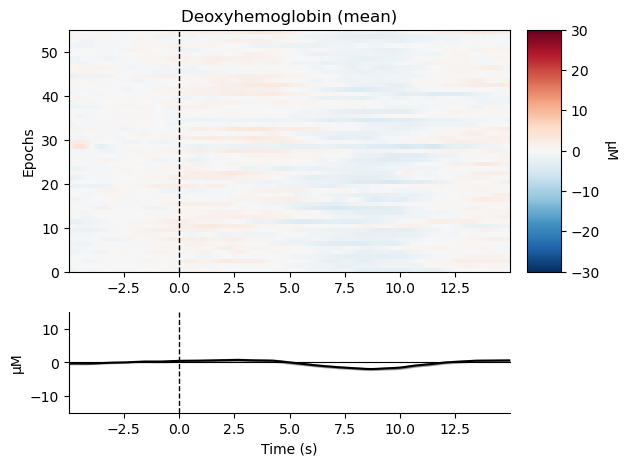

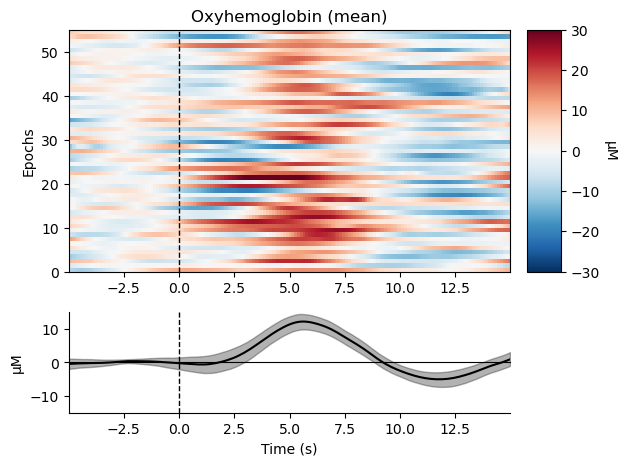

In [28]:
epochs['Tapping'].plot_image(combine='mean', vmin=-30, vmax=30,
                             ts_args=dict(ylim=dict(hbo=[-15, 15],
                                                    hbr=[-15, 15])));

Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


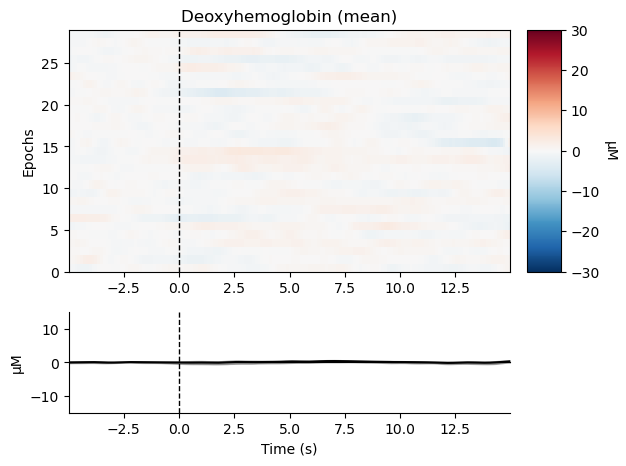

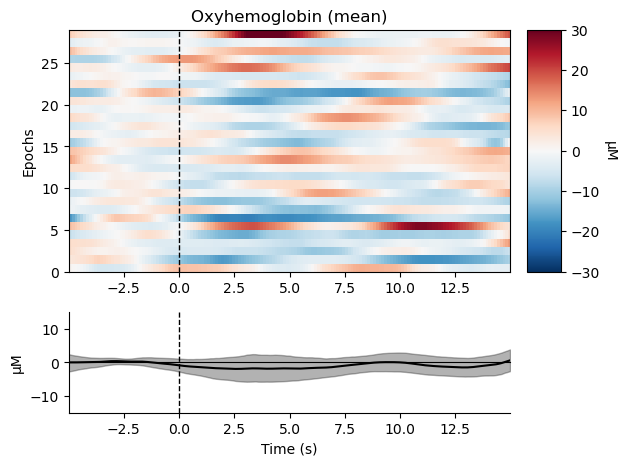

[<Figure size 640x480 with 3 Axes>, <Figure size 640x480 with 3 Axes>]

In [29]:
epochs['Control'].plot_image(combine='mean', vmin=-30, vmax=30,
                             ts_args=dict(ylim=dict(hbo=[-15, 15],
                                                    hbr=[-15, 15])))

# standard fNIRS response image

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


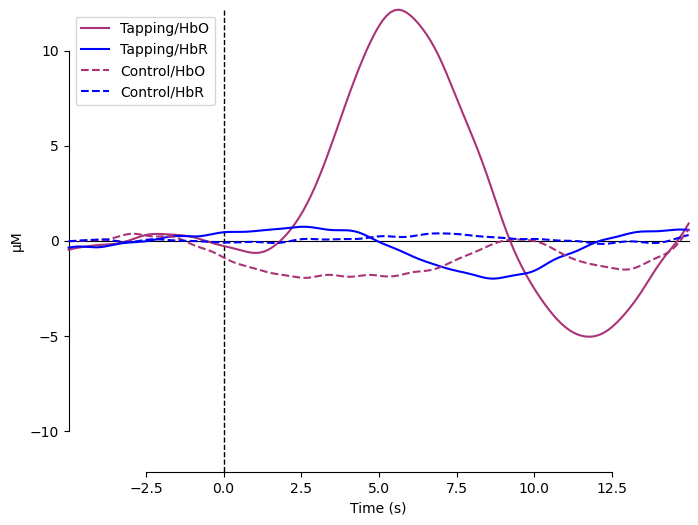

[<Figure size 800x600 with 1 Axes>]

In [32]:
evoked_dict = {'Tapping/HbO': epochs['Tapping'].average(picks='hbo'),
               'Tapping/HbR': epochs['Tapping'].average(picks='hbr'),
               'Control/HbO': epochs['Control'].average(picks='hbo'),
               'Control/HbR': epochs['Control'].average(picks='hbr')}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(Control=dict(linestyle='dashed'))

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                             colors=color_dict, styles=styles_dict)

No projector specified for this dataset. Please consider the method self.add_proj.


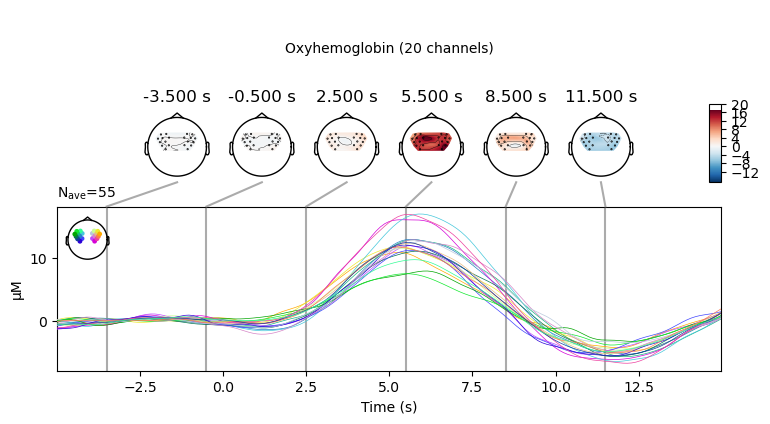

In [33]:
times = np.arange(-3.5, 13.2, 3.0)
topomap_args = dict(extrapolate='local')
epochs['Tapping'].average(picks='hbo').plot_joint(
    times=times, topomap_args=topomap_args);

In [ ]:
# HBO

times = np.arange(4.0, 11.0, 1.0)
epochs['Tapping/Left'].average(picks='hbo').plot_topomap(
    times=times, **topomap_args)
epochs['Tapping/Right'].average(picks='hbo').plot_topomap(
    times=times, **topomap_args)